# Test NAIP services

Script downloads RGB band NAIP images clipped to the grid cells from Firebreak. Images are saved in folder directory named after the Firebreak class label.

USDA NAIP Image service url: https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer

ESRI NAIP Image service url: https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer

MAXAR Image service url (WCS): https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?connectid=c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc

MAXAR Image service url (WMS): https://securewatch.digitalglobe.com/mapservice/wmsaccess?connectid=c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc

MAXAR Tiled basemap (Arc): https://securewatch.digitalglobe.com/earthservice/gis/c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc/rest/services/DigitalGlobe:ImageryTileService/MapServer/

MAXAR Un-Tiles basemap (Arc): https://securewatch.digitalglobe.com/mapservice/gis/c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc/rest/services/DigitalGlobe:ImageryService/MapServer/


In [1]:
import geopandas as gpd
import requests
import pandas as pd

In [2]:
#zipSHP = r'D:\Projects\WORKING\ML\vectors\Firebreak_2022_11_Labels\Labels_Merge.zip'
zipSHP = r'D:\Projects\WORKING\ML\vectors\Firebreak_2022_11_Labels\Inference_CO_WW_Merge.zip'

gpRead = gpd.read_file(zipSHP)

In [3]:
gpRead.head()

,STATE,BREAK_NAME,ID,geometry
0,Colorado,Wildland,0,"POLYGON ((-104.64454 37.84927, -104.64920 37.8..."
1,Colorado,Wildland,1,"POLYGON ((-108.62247 38.34639, -108.62713 38.3..."
2,Colorado,Wildland,2,"POLYGON ((-107.36947 38.52964, -107.37413 38.5..."
3,Colorado,Wildland,3,"POLYGON ((-108.43615 39.94319, -108.44081 39.9..."
4,Colorado,Wildland,4,"POLYGON ((-108.57589 38.86863, -108.58055 38.8..."


In [4]:
gdfQuery = gpRead[gpRead['BREAK_NAME'].isin(['Wildland','Water'])]
#gdfQuery = gpRead[gpRead['BREAK_NAME'].isin(['Wildland','Water','Agriculture','Scattered Residential','Low Density Residential','Medium Density Residential','High Density Residential','Urban','Urban Non-Residential'])]
#gdfQuery = gpRead[gpRead['STATE']=='Colorado']

len(gdfQuery)

971534

<Axes: >

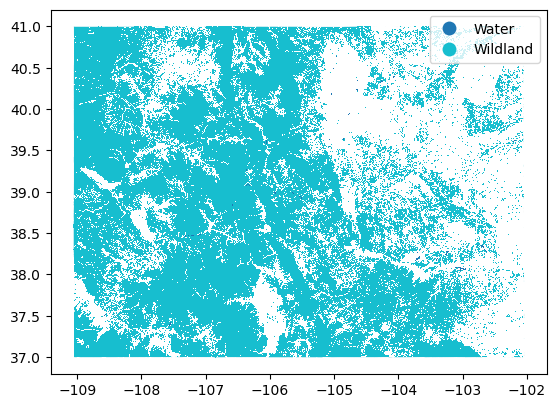

In [45]:
gdfQuery.plot('BREAK_NAME',legend=True)

In [5]:
gdf = gpd.GeoDataFrame(gdfQuery, geometry='geometry')

gdf['bounds'] = gdf['geometry'].apply(lambda x: x.bounds)

In [6]:
gdf.head()

,STATE,BREAK_NAME,ID,geometry,bounds
0,Colorado,Wildland,0,"POLYGON ((-104.64454 37.84927, -104.64920 37.8...","(-104.64919799999996, 37.84926900000005, -104...."
1,Colorado,Wildland,1,"POLYGON ((-108.62247 38.34639, -108.62713 38.3...","(-108.62712999999997, 38.34638700000005, -108...."
2,Colorado,Wildland,2,"POLYGON ((-107.36947 38.52964, -107.37413 38.5...","(-107.37412799999998, 38.529638000000034, -107..."
3,Colorado,Wildland,3,"POLYGON ((-108.43615 39.94319, -108.44081 39.9...","(-108.44080999999994, 39.94318500000003, -108...."
4,Colorado,Wildland,4,"POLYGON ((-108.57589 38.86863, -108.58055 38.8...","(-108.58054999999996, 38.86862800000006, -108...."


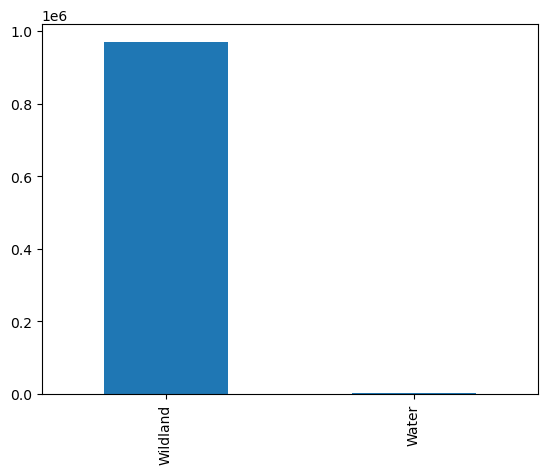

In [48]:
gdf['BREAK_NAME'].describe()
f = gdf['BREAK_NAME'].value_counts()
ax = f.plot.bar()

Check the formating and values in the bounds field of the data frame.

In [7]:
print(gdf['bounds'][79])
gdf['bounds']

(-103.42880199999996, 37.62505900000008, -103.42414399999996, 37.62861300000003)


0         (-104.64919799999996, 37.84926900000005, -104....
1         (-108.62712999999997, 38.34638700000005, -108....
2         (-107.37412799999998, 38.529638000000034, -107...
3         (-108.44080999999994, 39.94318500000003, -108....
4         (-108.58054999999996, 38.86862800000006, -108....
                                ...                        
971529    (-103.61512199999999, 38.05628900000005, -103....
971530    (-103.07945199999995, 38.08846500000004, -103....
971531    (-103.68033399999996, 38.199403000000075, -103...
971532    (-102.77202399999999, 38.34279800000007, -102....
971533    (-106.26086599999996, 39.01699000000008, -106....
Name: bounds, Length: 971534, dtype: object

Check the data type of the bounds field to make sure it is a tuple

In [8]:
print(gdf['bounds'][79])
type(gdf['bounds'][79])

(-103.42880199999996, 37.62505900000008, -103.42414399999996, 37.62861300000003)


tuple

Function to convert the lat,long bounds field from Decimal Degrees to meters (long,lat)

In [9]:
from pyproj import CRS, Transformer

proj = Transformer.from_crs(4326,3857,always_xy=True)

def get_meters(x):
    x_min,y_min,x_max,y_max = x[0],x[1],x[2],x[3]
    ll   = proj.transform(x_min,y_min)
    ur   = proj.transform(x_max,y_max)
    bbox = ll + ur
    return(bbox)


In [10]:
get_meters(gdf['bounds'][79])

(-11513641.571998311,
 4526593.790225361,
 -11513123.045810195,
 4527093.320001631)

In [11]:
gdf['bounds_m'] = gdf['bounds'].apply(get_meters)

In [12]:
gdf.head()

,STATE,BREAK_NAME,ID,geometry,bounds,bounds_m
0,Colorado,Wildland,0,"POLYGON ((-104.64454 37.84927, -104.64920 37.8...","(-104.64919799999996, 37.84926900000005, -104....","(-11649495.433284458, 4558154.4061500495, -116..."
1,Colorado,Wildland,1,"POLYGON ((-108.62247 38.34639, -108.62713 38.3...","(-108.62712999999997, 38.34638700000005, -108....","(-12092316.797934728, 4628474.906879766, -1209..."
2,Colorado,Wildland,2,"POLYGON ((-107.36947 38.52964, -107.37413 38.5...","(-107.37412799999998, 38.529638000000034, -107...","(-11952833.253331777, 4654518.4630813105, -119..."
3,Colorado,Wildland,3,"POLYGON ((-108.43615 39.94319, -108.44081 39.9...","(-108.44080999999994, 39.94318500000003, -108....","(-12071575.750410123, 4857689.510105316, -1207..."
4,Colorado,Wildland,4,"POLYGON ((-108.57589 38.86863, -108.58055 38.8...","(-108.58054999999996, 38.86862800000006, -108....","(-12087131.536053576, 4702871.0926693315, -120..."


In [13]:
import os
#save_dir = r'D:/Projects/WORKING/ML/imagery/CO_Water_Wildland'
save_dir = r'D:\Projects\WORKING\ML\imagery\MAXAR'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for label_name in gdf['BREAK_NAME'].str.lower().str.replace(' ','_').str.replace('-','_').unique():
    print(label_name)
    if not os.path.exists(os.path.join(save_dir,label_name)):
        os.makedirs(os.path.join(save_dir,label_name))

wildland
water


In [14]:
gdf['file_save'] = gdf.apply(lambda row: os.path.join(save_dir + '/',row['BREAK_NAME'].lower().replace(' ','_').replace('-','_') + '/' + str(row['ID'])+'.jpg'),axis=1)

In [15]:
gdf.head()

,STATE,BREAK_NAME,ID,geometry,bounds,bounds_m,file_save
0,Colorado,Wildland,0,"POLYGON ((-104.64454 37.84927, -104.64920 37.8...","(-104.64919799999996, 37.84926900000005, -104....","(-11649495.433284458, 4558154.4061500495, -116...",D:\Projects\WORKING\ML\imagery\MAXAR/wildland/...
1,Colorado,Wildland,1,"POLYGON ((-108.62247 38.34639, -108.62713 38.3...","(-108.62712999999997, 38.34638700000005, -108....","(-12092316.797934728, 4628474.906879766, -1209...",D:\Projects\WORKING\ML\imagery\MAXAR/wildland/...
2,Colorado,Wildland,2,"POLYGON ((-107.36947 38.52964, -107.37413 38.5...","(-107.37412799999998, 38.529638000000034, -107...","(-11952833.253331777, 4654518.4630813105, -119...",D:\Projects\WORKING\ML\imagery\MAXAR/wildland/...
3,Colorado,Wildland,3,"POLYGON ((-108.43615 39.94319, -108.44081 39.9...","(-108.44080999999994, 39.94318500000003, -108....","(-12071575.750410123, 4857689.510105316, -1207...",D:\Projects\WORKING\ML\imagery\MAXAR/wildland/...
4,Colorado,Wildland,4,"POLYGON ((-108.57589 38.86863, -108.58055 38.8...","(-108.58054999999996, 38.86862800000006, -108....","(-12087131.536053576, 4702871.0926693315, -120...",D:\Projects\WORKING\ML\imagery\MAXAR/wildland/...


In [16]:
gdf['file_save'][1344]

'D:\\Projects\\WORKING\\ML\\imagery\\MAXAR/wildland/1344.jpg'

## USDA Image Server Request

Try to make an ExportImage request using the USDA image server. This service was working, but not anymore. There are issues to figure out.

USDA NAIP Image service url: https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer

In [66]:
def get_save_url(x):
    #url = """https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={}&CRS=EPSG:4326&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"""
    url = """https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={}&CRS=EPSG:3857&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE"""
    return url.format(','.join([str(val) for val in [x[0],x[1],x[2],x[3]]]))

In [67]:
gdf['url'] = gdf['bounds_m'].apply(get_save_url)

In [68]:
gdf['url'][971529]

'https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=-11534382.619522916,4587380.615275386,-11533864.093334801,4587885.902017566&CRS=EPSG:3857&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE'

## ESRI Request

Try to make an ExportImage request using the ESRI NAIP image server. Need to be signed into my esri account on web browser? need to test this.

ESRI NAIP Image service url: https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer

In [69]:
def get_esri_url(x):
    url = """https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer/exportImage?bbox={}&bboxSR=4326&size=256,256&format=jpg&f=image"""
    #print(url.format(','.join([str(val) for val in [x[0],x[1],x[2],x[3]]])))
    return url.format(','.join([str(val) for val in [x[0],x[1],x[2],x[3]]]))

In [70]:
gdf['esri_url'] = gdf['bounds'].apply(get_esri_url)

In [71]:
gdf['esri_url'][1344]

'https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer/exportImage?bbox=-108.00761599999998,40.61831700000005,-108.00295799999998,40.622025000000065&bboxSR=4326&size=256,256&format=jpg&f=image'

## MAXAR Request

Try to make an ExportImage request using the MAXAR image server. Need to be signed into my maxar account on web browser? need to test this.

MAXAR Image service url (WCS): https://securewatch.digitalglobe.com/deliveryservice/wcsaccess?connectid=c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc

MAXAR Image service url (WMS): https://securewatch.digitalglobe.com/mapservice/wmsaccess?connectid=c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc

MAXAR Tiled basemap (Arc): https://securewatch.digitalglobe.com/earthservice/gis/c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc/rest/services/DigitalGlobe:ImageryTileService/MapServer/

MAXAR Un-Tiles basemap (Arc): https://securewatch.digitalglobe.com/mapservice/gis/c8475cb2-647b-44a2-a2dd-a9ccf2dbcbbc/rest/services/DigitalGlobe:ImageryService/MapServer/

In [ ]:
def get_maxar_url(x):
    url = """https://naip.arcgis.com/arcgis/rest/services/NAIP/ImageServer/exportImage?bbox={}&bboxSR=4326&size=256,256&format=jpg&f=image"""
    #print(url.format(','.join([str(val) for val in [x[0],x[1],x[2],x[3]]])))
    return url.format(','.join([str(val) for val in [x[0],x[1],x[2],x[3]]]))

In [ ]:
gdf['maxar_url'] = gdf['bounds'].apply(get_maxar_url)

In [ ]:
gdf['maxar_url'][1344]

## Image Download

Attempt to use the url from the geodata frame to download an image tile. This step uses Requests to write the url result to a file location on the local drive. It has not been working with the original URL request. 

Sometimes not all images are downloaded in one query. A script to change the input dataframe is needed to select only the images that were missed in the last download.

In [103]:
filter_df = gdf[gdf['ID'] > 92612] 
filter_df

,STATE,BREAK_NAME,ID,geometry,bounds,bounds_m,file_save,url,esri_url
92613,Colorado,Wildland,92613,"POLYGON ((-106.45184 40.70365, -106.45650 40.7...","(-106.45650199999994, 40.703651000000036, -106...","(-11850683.594273103, 4968728.033857721, -1185...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
92614,Colorado,Wildland,92614,"POLYGON ((-103.57320 38.75305, -103.57786 38.7...","(-103.57785799999999, 38.75304700000004, -103....","(-11530234.410017997, 4686359.154448238, -1152...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
92615,Colorado,Wildland,92615,"POLYGON ((-105.76246 39.10035, -105.76712 39.1...","(-105.76711799999998, 39.10035400000004, -105....","(-11773941.718432078, 4736056.6332533555, -117...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
92616,Colorado,Wildland,92616,"POLYGON ((-109.03238 40.15275, -109.03703 40.1...","(-109.03703399999995, 40.15275100000008, -109....","(-12137947.102488851, 4888164.53025307, -12137...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
92617,Colorado,Wildland,92617,"POLYGON ((-103.92255 40.37774, -103.92721 40.3...","(-103.92720799999995, 40.377743000000066, -103...","(-11569123.874126622, 4920987.660232814, -1156...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
...,...,...,...,...,...,...,...,...,...
971529,Colorado,Water,971529,"POLYGON ((-103.61046 38.05629, -103.61512 38.0...","(-103.61512199999999, 38.05628900000005, -103....","(-11534382.619522916, 4587380.615275386, -1153...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
971530,Colorado,Water,971530,"POLYGON ((-103.07479 38.08847, -103.07945 38.0...","(-103.07945199999995, 38.08846500000004, -103....","(-11474752.107889678, 4591930.499134556, -1147...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
971531,Colorado,Water,971531,"POLYGON ((-103.67568 38.19940, -103.68033 38.1...","(-103.68033399999996, 38.199403000000075, -103...","(-11541641.986156525, 4607633.192264598, -1154...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...
971532,Colorado,Water,971532,"POLYGON ((-102.76737 38.34280, -102.77202 38.3...","(-102.77202399999999, 38.34279800000007, -102....","(-11440529.37947409, 4627965.498710136, -11440...",D:/Projects/WORKING/ML/imagery/CO_Water_Wildla...,https://gis.apfo.usda.gov/arcgis/services/NAIP...,https://naip.arcgis.com/arcgis/rest/services/N...


In [104]:
def save_data(url,path):
    res = requests.get(url)
    with open(path,'wb') as f:
        f.write(res.content)
    return res.status_code

#url_list = gdf['url'].tolist()
#save_list = gdf['file_save'].tolist()

url_list  = filter_df['url'].tolist()
save_list = filter_df['file_save'].tolist()

In [105]:
url_list

['https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=-11850683.594273103,4968728.033857721,-11850165.068084989,4969273.271592556&CRS=EPSG:3857&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE',
 'https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=-11530234.410017997,4686359.154448238,-11529715.88382988,4686874.33247388&CRS=EPSG:3857&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORMAT_OPTIONS=dpi:96&TRANSPARENT=TRUE',
 'https://gis.apfo.usda.gov/arcgis/services/NAIP/USDA_CONUS_PRIME/ImageServer/WMSServer?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX=-11773941.718432078,4736056.6332533555,-11773423.192243962,4736576.921992754&CRS=EPSG:3857&WIDTH=256&HEIGHT=256&LAYERS=0&STYLES=&FORMAT=image/jpeg&DPI=96&MAP_RESOLUTION=96&FORM

In [106]:
from joblib import Parallel,delayed
import time
from datetime import datetime as dt

# Start a timer
startTime = dt.now()

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

cnt    = 0
newlst = zip(url_list,save_list)

Parallel(n_jobs=10,backend='threading')
for url,path in newlst:
    cnt += 1
    runT = dt.now()-startTime
    print(f'{cnt} {runT}')

    status_codes = delayed(save_data(url=url,path=path))
    #time.sleep(3)
    
print("Complete! Total runtime: {0}".format(dt.now()-startTime))

1 0:00:00.012756
2 0:00:01.366300
3 0:00:02.722399
4 0:00:03.531048
5 0:00:05.004529
6 0:00:06.181628
7 0:00:06.888173
8 0:00:08.787585
9 0:00:10.023444
10 0:00:10.963366
11 0:00:12.283677
12 0:00:13.750953
13 0:00:14.721673
14 0:00:15.629880
15 0:00:17.334456
16 0:00:18.928202
17 0:00:20.289047
18 0:00:21.654280
19 0:00:22.614372
20 0:00:23.540524
21 0:00:24.649884
22 0:00:26.115216
23 0:00:26.991691
24 0:00:28.102512
25 0:00:29.118135
26 0:00:29.978977
27 0:00:31.594212
28 0:00:32.469208
29 0:00:33.452641
30 0:00:35.302701
31 0:00:36.852505
32 0:00:37.666488
33 0:00:38.588344
34 0:00:39.478972
35 0:00:41.145475
36 0:00:42.415492
37 0:00:43.355935
38 0:00:44.309046
39 0:00:45.373033
40 0:00:46.902794
41 0:00:47.646939
42 0:00:48.428209
43 0:00:50.085901
44 0:00:51.149863
45 0:00:53.320786
46 0:00:54.191885
47 0:00:55.428179
48 0:00:57.010699
49 0:00:57.996538
50 0:00:59.763626
51 0:01:01.439903
52 0:01:02.550735
53 0:01:04.118605
54 0:01:05.102981
55 0:01:06.213821
56 0:01:07.951140
5

438 0:08:56.466044
439 0:08:58.290756
440 0:08:59.275132
441 0:09:00.698467
442 0:09:02.439789
443 0:09:03.931866
444 0:09:05.384996
445 0:09:06.467999
446 0:09:07.838601
447 0:09:08.604231
448 0:09:09.901103
449 0:09:11.641333
450 0:09:12.627179
451 0:09:13.704326
452 0:09:15.118870
453 0:09:16.595426
454 0:09:17.733129
455 0:09:18.735580
456 0:09:20.205790
457 0:09:21.787324
458 0:09:22.625215
459 0:09:23.651632
460 0:09:24.897672
461 0:09:25.538301
462 0:09:26.329796
463 0:09:27.874240
464 0:09:29.322992
465 0:09:30.565644
466 0:09:31.798061
467 0:09:33.152063
468 0:09:34.424061
469 0:09:36.226276
470 0:09:37.805376
471 0:09:39.624712
472 0:09:40.974328
473 0:09:42.301481
474 0:09:43.133500
475 0:09:44.615930
476 0:09:46.027060
477 0:09:47.249705
478 0:09:48.535841
479 0:09:49.435747
480 0:09:50.655960
481 0:09:51.660353
482 0:09:52.875682
483 0:09:53.796110
484 0:09:54.699446
485 0:09:56.308296
486 0:09:57.730171
487 0:09:59.360055
488 0:10:00.246771
489 0:10:01.413766
490 0:10:03.

870 0:17:57.010701
871 0:17:57.855432
872 0:17:59.735294
873 0:18:00.594179
874 0:18:01.637151
875 0:18:03.150821
876 0:18:04.623966
877 0:18:05.795838
878 0:18:06.844181
879 0:18:08.253045
880 0:18:09.897399
881 0:18:11.150331
882 0:18:12.675719
883 0:18:13.828061
884 0:18:14.527282
885 0:18:16.475519
886 0:18:17.729429
887 0:18:19.426695
888 0:18:20.478451
889 0:18:21.126893
890 0:18:22.533622
891 0:18:23.104926
892 0:18:24.900806
893 0:18:25.454514
894 0:18:26.179130
895 0:18:27.784598
896 0:18:28.505299
897 0:18:29.936941
898 0:18:30.754324
899 0:18:32.228931
900 0:18:33.301195
901 0:18:33.934986
902 0:18:34.623460
903 0:18:35.513600
904 0:18:36.977465
905 0:18:38.422835
906 0:18:40.048746
907 0:18:41.839768
908 0:18:42.831956
909 0:18:44.173263
910 0:18:44.827558
911 0:18:46.466228
912 0:18:47.522883
913 0:18:49.088304
914 0:18:49.894939
915 0:18:51.878337
916 0:18:52.796304
917 0:18:53.760664
918 0:18:54.909099
919 0:18:55.784096
920 0:18:56.673742
921 0:18:57.993088
922 0:18:59.

1287 0:26:32.803881
1288 0:26:34.561685
1289 0:26:35.908371
1290 0:26:36.696450
1291 0:26:37.829266
1292 0:26:39.069503
1293 0:26:40.679869
1294 0:26:41.629066
1295 0:26:42.184734
1296 0:26:44.062658
1297 0:26:45.650065
1298 0:26:47.674475
1299 0:26:48.839513
1300 0:26:50.127597
1301 0:26:51.193028
1302 0:26:52.032869
1303 0:26:53.455721
1304 0:26:54.339513
1305 0:26:55.904934
1306 0:26:57.314118
1307 0:26:57.940094
1308 0:26:59.327809
1309 0:27:00.036287
1310 0:27:02.027496
1311 0:27:03.000150
1312 0:27:03.702306
1313 0:27:05.049951
1314 0:27:06.121243
1315 0:27:07.622220
1316 0:27:08.251125
1317 0:27:09.027490
1318 0:27:09.954249
1319 0:27:12.206205
1320 0:27:13.524091
1321 0:27:14.786768
1322 0:27:16.504538
1323 0:27:17.356123
1324 0:27:18.448880
1325 0:27:19.803368
1326 0:27:20.733064
1327 0:27:21.837545
1328 0:27:23.236960
1329 0:27:24.733053
1330 0:27:25.734030
1331 0:27:26.924937
1332 0:27:27.763807
1333 0:27:28.738415
1334 0:27:29.788228
1335 0:27:30.712054
1336 0:27:32.044079


1697 0:34:49.494072
1698 0:34:50.798753
1699 0:34:51.503828
1700 0:34:52.478444
1701 0:34:54.448165
1702 0:34:55.864182
1703 0:34:56.642994
1704 0:34:57.947670
1705 0:34:59.224040
1706 0:35:00.072674
1707 0:35:01.178153
1708 0:35:01.978921
1709 0:35:02.827551
1710 0:35:04.350995
1711 0:35:05.985758
1712 0:35:07.751387
1713 0:35:09.059973
1714 0:35:10.013110
1715 0:35:10.728431
1716 0:35:11.414987
1717 0:35:13.003820
1718 0:35:13.890550
1719 0:35:14.433511
1720 0:35:15.958904
1721 0:35:16.942293
1722 0:35:18.077058
1723 0:35:19.256742
1724 0:35:20.418856
1725 0:35:21.310454
1726 0:35:22.270419
1727 0:35:23.004790
1728 0:35:24.380278
1729 0:35:25.535551
1730 0:35:26.662504
1731 0:35:27.621494
1732 0:35:28.959388
1733 0:35:30.331446
1734 0:35:31.484766
1735 0:35:32.589271
1736 0:35:33.736721
1737 0:35:34.497460
1738 0:35:35.387111
1739 0:35:37.137107
1740 0:35:38.125886
1741 0:35:38.992085
1742 0:35:40.285054
1743 0:35:41.620992
1744 0:35:42.716691
1745 0:35:43.331931
1746 0:35:43.894426


2107 0:42:53.554367
2108 0:42:54.784838
2109 0:42:55.956726
2110 0:42:56.985026
2111 0:42:58.748698
2112 0:42:59.460613
2113 0:43:00.788737
2114 0:43:01.616861
2115 0:43:03.360999
2116 0:43:04.168615
2117 0:43:05.266272
2118 0:43:06.092452
2119 0:43:07.240396
2120 0:43:08.314642
2121 0:43:08.953287
2122 0:43:10.811680
2123 0:43:11.497232
2124 0:43:12.554842
2125 0:43:13.811679
2126 0:43:15.894683
2127 0:43:17.000155
2128 0:43:17.636875
2129 0:43:18.874194
2130 0:43:20.197422
2131 0:43:21.729152
2132 0:43:22.540674
2133 0:43:23.470360
2134 0:43:24.661771
2135 0:43:25.641262
2136 0:43:26.546534
2137 0:43:27.197952
2138 0:43:28.475244
2139 0:43:29.331700
2140 0:43:30.725243
2141 0:43:31.929348
2142 0:43:33.316078
2143 0:43:34.152975
2144 0:43:35.585104
2145 0:43:36.505025
2146 0:43:37.319478
2147 0:43:38.904444
2148 0:43:40.398574
2149 0:43:41.317522
2150 0:43:41.952288
2151 0:43:43.184713
2152 0:43:44.088046
2153 0:43:45.437643
2154 0:43:46.328263
2155 0:43:47.810683
2156 0:43:48.923476


2517 0:51:01.639575
2518 0:51:03.121993
2519 0:51:04.569736
2520 0:51:06.025794
2521 0:51:07.445719
2522 0:51:08.795318
2523 0:51:10.542404
2524 0:51:11.945707
2525 0:51:13.655673
2526 0:51:14.702542
2527 0:51:15.915451
2528 0:51:17.350016
2529 0:51:17.890529
2530 0:51:18.917887
2531 0:51:20.830955
2532 0:51:21.757723
2533 0:51:23.291907
2534 0:51:24.494105
2535 0:51:25.731345
2536 0:51:27.195206
2537 0:51:29.152239
2538 0:51:30.239153
2539 0:51:31.094623
2540 0:51:32.441790
2541 0:51:33.499407
2542 0:51:34.964267
2543 0:51:36.071671
2544 0:51:37.192764
2545 0:51:38.676164
2546 0:51:39.414443
2547 0:51:40.222095
2548 0:51:41.762098
2549 0:51:42.595117
2550 0:51:44.691793
2551 0:51:45.678605
2552 0:51:47.252817
2553 0:51:48.019478
2554 0:51:49.476452
2555 0:51:50.310435
2556 0:51:51.082896
2557 0:51:53.069228
2558 0:51:54.767467
2559 0:51:55.508689
2560 0:51:56.481330
2561 0:51:58.285054
2562 0:51:59.646859
2563 0:52:00.557988
2564 0:52:01.450562
2565 0:52:03.142945
2566 0:52:05.043344


2927 0:59:10.943019
2928 0:59:11.867823
2929 0:59:12.641270
2930 0:59:13.212567
2931 0:59:14.109043
2932 0:59:15.709134
2933 0:59:16.389792
2934 0:59:17.043115
2935 0:59:18.810692
2936 0:59:20.339988
2937 0:59:21.292140
2938 0:59:22.429831
2939 0:59:24.105611
2940 0:59:25.456211
2941 0:59:26.277483
2942 0:59:27.674943
2943 0:59:28.659340
2944 0:59:30.194966
2945 0:59:31.697906
2946 0:59:32.865859
2947 0:59:34.046530
2948 0:59:34.843397
2949 0:59:35.736988
2950 0:59:36.962538
2951 0:59:38.542614
2952 0:59:39.297501
2953 0:59:40.724254
2954 0:59:42.558727
2955 0:59:43.687634
2956 0:59:44.817515
2957 0:59:45.997200
2958 0:59:47.062632
2959 0:59:47.822399
2960 0:59:48.498193
2961 0:59:49.938604
2962 0:59:50.780403
2963 0:59:52.153448
2964 0:59:53.477667
2965 0:59:54.303836
2966 0:59:54.955203
2967 0:59:56.589478
2968 0:59:57.290651
2969 0:59:58.890261
2970 0:59:59.729140
2971 1:00:00.548460
2972 1:00:01.856081
2973 1:00:02.796510
2974 1:00:03.395141
2975 1:00:05.014278
2976 1:00:06.203735


3337 1:07:08.038958
3338 1:07:08.779197
3339 1:07:09.531151
3340 1:07:10.369046
3341 1:07:12.099023
3342 1:07:13.650778
3343 1:07:14.339254
3344 1:07:15.008212
3345 1:07:16.635147
3346 1:07:17.964272
3347 1:07:19.172257
3348 1:07:20.308018
3349 1:07:22.031635
3350 1:07:23.381246
3351 1:07:24.254292
3352 1:07:25.524790
3353 1:07:26.285051
3354 1:07:27.060439
3355 1:07:28.561415
3356 1:07:30.031147
3357 1:07:30.841684
3358 1:07:31.774303
3359 1:07:32.644422
3360 1:07:34.134652
3361 1:07:35.647349
3362 1:07:36.923712
3363 1:07:38.345597
3364 1:07:39.983770
3365 1:07:41.081425
3366 1:07:41.761112
3367 1:07:43.049212
3368 1:07:44.058968
3369 1:07:45.439825
3370 1:07:45.954479
3371 1:07:46.900766
3372 1:07:47.943728
3373 1:07:49.469132
3374 1:07:50.579468
3375 1:07:51.557006
3376 1:07:52.516042
3377 1:07:53.369024
3378 1:07:54.878780
3379 1:07:55.784058
3380 1:07:57.063367
3381 1:07:58.099486
3382 1:07:58.854384
3383 1:08:00.181538
3384 1:08:01.605348
3385 1:08:02.619992
3386 1:08:03.539909


3747 1:14:53.136880
3748 1:14:54.365872
3749 1:14:55.792143
3750 1:14:56.589018
3751 1:14:57.777981
3752 1:14:58.638821
3753 1:14:59.765287
3754 1:15:01.109032
3755 1:15:02.004051
3756 1:15:02.818015
3757 1:15:03.731589
3758 1:15:05.014299
3759 1:15:07.045555
3760 1:15:08.497699
3761 1:15:09.091456
3762 1:15:10.249162
3763 1:15:11.563144
3764 1:15:12.206683
3765 1:15:13.655904
3766 1:15:14.442519
3767 1:15:15.263806
3768 1:15:16.575819
3769 1:15:17.278950
3770 1:15:17.967912
3771 1:15:18.859999
3772 1:15:19.611462
3773 1:15:20.580213
3774 1:15:22.084602
3775 1:15:22.898573
3776 1:15:24.141248
3777 1:15:25.470835
3778 1:15:26.919078
3779 1:15:28.045546
3780 1:15:29.532357
3781 1:15:30.532850
3782 1:15:31.439095
3783 1:15:33.186165
3784 1:15:34.742800
3785 1:15:35.620732
3786 1:15:36.448860
3787 1:15:37.590948
3788 1:15:38.889779
3789 1:15:39.875612
3790 1:15:41.406860
3791 1:15:42.701301
3792 1:15:43.546511
3793 1:15:44.861939
3794 1:15:45.783817
3795 1:15:46.674440
3796 1:15:47.299439


4157 1:22:19.335867
4158 1:22:20.274828
4159 1:22:21.227954
4160 1:22:22.947677
4161 1:22:23.872967
4162 1:22:24.826092
4163 1:22:25.686934
4164 1:22:27.275799
4165 1:22:28.903728
4166 1:22:29.794350
4167 1:22:31.202070
4168 1:22:31.955012
4169 1:22:32.925208
4170 1:22:34.000894
4171 1:22:35.551190
4172 1:22:36.723067
4173 1:22:38.083908
4174 1:22:39.275310
4175 1:22:40.025304
4176 1:22:40.917394
4177 1:22:42.724520
4178 1:22:44.169835
4179 1:22:45.154232
4180 1:22:46.124423
4181 1:22:47.720614
4182 1:22:48.808994
4183 1:22:50.152741
4184 1:22:50.982342
4185 1:22:52.141509
4186 1:22:53.465727
4187 1:22:54.622468
4188 1:22:55.318276
4189 1:22:56.068265
4190 1:22:56.818278
4191 1:22:57.443265
4192 1:22:58.872461
4193 1:23:00.263088
4194 1:23:01.748938
4195 1:23:02.754298
4196 1:23:04.326078
4197 1:23:05.029198
4198 1:23:06.155662
4199 1:23:07.375879
4200 1:23:09.232810
4201 1:23:10.359279
4202 1:23:11.124900
4203 1:23:11.765523
4204 1:23:13.107910
4205 1:23:13.766011
4206 1:23:15.239646


4567 1:30:12.940594
4568 1:30:14.054864
4569 1:30:15.018721
4570 1:30:15.918135
4571 1:30:16.614424
4572 1:30:17.938660
4573 1:30:19.124198
4574 1:30:20.265834
4575 1:30:21.152502
4576 1:30:21.987467
4577 1:30:23.459154
4578 1:30:24.611489
4579 1:30:25.874195
4580 1:30:26.795613
4581 1:30:27.576814
4582 1:30:30.096389
4583 1:30:31.093509
4584 1:30:32.544590
4585 1:30:33.549493
4586 1:30:34.793634
4587 1:30:36.170600
4588 1:30:37.195959
4589 1:30:38.169595
4590 1:30:39.371741
4591 1:30:40.667671
4592 1:30:41.495304
4593 1:30:42.097817
4594 1:30:42.950355
4595 1:30:43.762863
4596 1:30:45.327318
4597 1:30:46.652510
4598 1:30:47.609540
4599 1:30:48.874189
4600 1:30:50.502106
4601 1:30:51.949387
4602 1:30:53.258970
4603 1:30:54.188159
4604 1:30:54.896162
4605 1:30:56.531908
4606 1:30:57.749689
4607 1:30:58.853192
4608 1:30:59.860990
4609 1:31:01.491846
4610 1:31:02.630527
4611 1:31:03.469383
4612 1:31:05.986974
4613 1:31:07.690585
4614 1:31:08.511872
4615 1:31:09.255025
4616 1:31:11.276513


ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))